In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import pickle
from PIL import Image

In [2]:
loc=r'E:\FitnessTracker'

In [3]:
# Initialize DataFrame
# df = pd.DataFrame(columns=['points'])
# Initialize DataFrame
features_list = []
yoga_pose_labels = []


In [4]:
# Set up MediaPipe Pose and DataFrame
mp_pose = mp.solutions.pose

In [12]:
# List all directories (poses) in the image root directory
image_root_dir=(r'E:\FitnessTracker\image_root_dir')
pose_directories = os.listdir(image_root_dir)

In [13]:
print(pose_directories)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [14]:
# Function to remove corrupted images
def removeCorruptedImages(path):
    if os.path.isfile(path):
        try:
            img = Image.open(path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print('Bad file:', path)
            os.remove(path)
            print(f"Removed file: {path}")
    elif os.path.isdir(path):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print('Bad file:', file_path)
                os.remove(file_path)
                print(f"Removed file: {file_path}")

In [15]:
# Process each pose directory
for pose_name in pose_directories:
    pose_dir_path = os.path.join(image_root_dir, pose_name)
    if not os.path.isdir(pose_dir_path):
        continue

    # List all images in the current pose directory
    image_files = os.listdir(pose_dir_path)

    for image_name in image_files:
        image_path = os.path.join(pose_dir_path, image_name)
        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            frame = cv2.imread(image_path)
            if frame is None:
                print(f"Error: Image at {image_path} could not be read.")
                continue

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True

            if results.pose_landmarks:
                try:
                    landmarks = results.pose_landmarks.landmark

                    # Extract required landmark coordinates
                    feature = [
                        landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y,
                        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y,
                        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y,
                        landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y,
                        landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y,
                        landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y
                    ]

                    # Append feature and label to the list
                    features_list.append(feature)
                    yoga_pose_labels.append(pose_name)

                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
            else:
                print(f"No landmarks detected for image {image_path}.")
                removeCorruptedImages(image_path)

No landmarks detected for image E:\FitnessTracker\image_root_dir\downdog\00000010.png.
No landmarks detected for image E:\FitnessTracker\image_root_dir\downdog\00000080.jpg.
No landmarks detected for image E:\FitnessTracker\image_root_dir\downdog\00000120.jpg.
No landmarks detected for image E:\FitnessTracker\image_root_dir\warrior2\00000025.png.
No landmarks detected for image E:\FitnessTracker\image_root_dir\warrior2\00000039.png.


In [16]:
# Create DataFrame for features and labels
features_df = pd.DataFrame(features_list)
labels_df = pd.DataFrame(yoga_pose_labels, columns=['label'])

In [17]:
# Concatenate features and labels DataFrames
final_df = pd.concat([features_df, labels_df], axis=1)

In [18]:
# Save the DataFrame to a CSV file
final_df.to_csv("yoga_pose_data.csv", index=False)

In [19]:
# Load CSV data
df = pd.read_csv("yoga_pose_data.csv")

In [20]:
# Encode labels
lb = LabelEncoder()
y = lb.fit_transform(df['label'])

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label'], axis=1), y, test_size=0.1, shuffle=True, random_state=2)

In [22]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [23]:
# Train and evaluate SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.9148936170212766


In [24]:
# Train and evaluate Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", metrics.accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8723404255319149


In [25]:
# Train and evaluate Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Accuracy:", metrics.accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9787234042553191


In [26]:
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9574468085106383


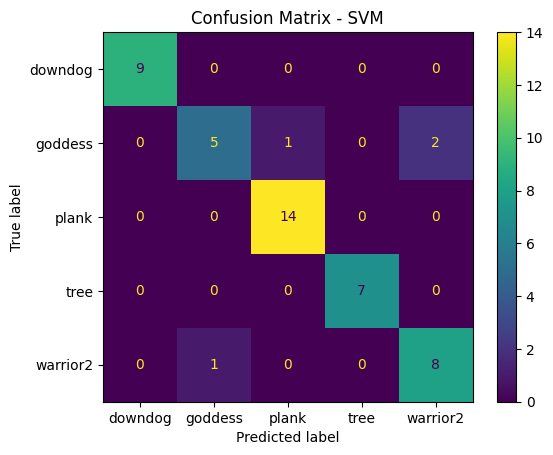

In [27]:
# Confusion Matrix for SVM
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, display_labels=lb.classes_)
plt.title("Confusion Matrix - SVM")
plt.show()

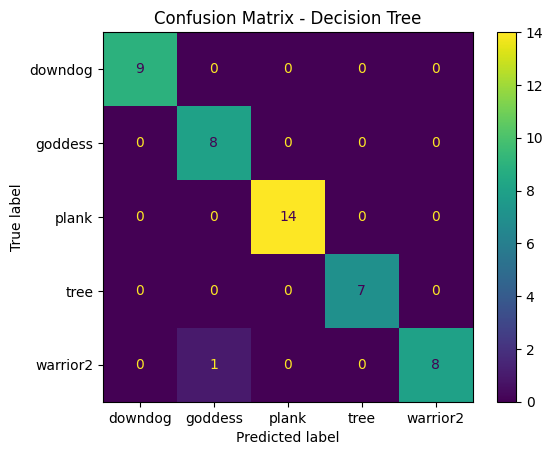

In [28]:
# Confusion Matrix for Decision Tree
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test, display_labels=lb.classes_)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

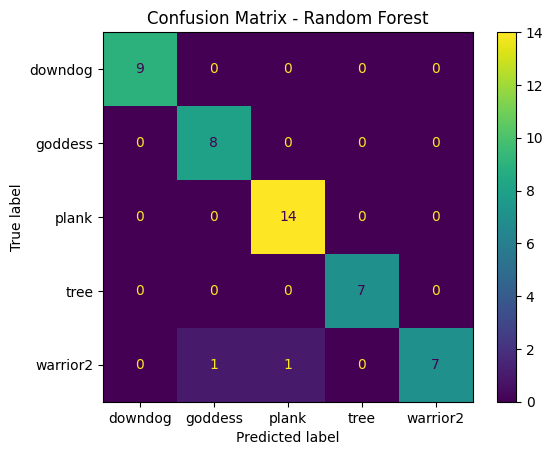

In [29]:
# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=lb.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [30]:
best=0
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['label'],axis=1), y, test_size=0.2, shuffle=True, random_state=2)
    model = RandomForestClassifier(bootstrap=False,max_depth=8,max_features='sqrt',min_samples_leaf=1,min_samples_split=2,n_estimators=100)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    if acc > best:
        best = acc
        with open("humanmodel.pickel", "wb") as f:
            pickle.dump(model, f)
print(best)

0.956989247311828


In [31]:
pickle_in = open("humanmodel.pickel", "rb")
model = pickle.load(pickle_in)

In [32]:
predictions = model.predict(X_test)

In [33]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [34]:
def calculate_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [35]:
def start_yoga():
    cap = cv2.VideoCapture(0)  # Initialize the webcam capture
    count = 0  # Counter for capturing frames
    frameloc = []  # List to store pose landmarks
    pred = ''  # Variable to store the predicted pose
    count1 = 0  # Counter for 'tree' pose
    count2 = 0  # Counter for 'goddess' pose
    count3 = 0  # Counter for 'plank' pose
    count4 = 0  # Counter for 'warrior' pose
    count5 = 0  # Counter for 'downdog' pose
    t = 200  # Threshold count for each pose

    # Initialize MediaPipe Pose with detection and tracking confidence thresholds
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()  # Read frame from webcam

            if not ret:
                print("Error: Failed to capture frame.")
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB
            image.flags.writeable = False  # Disable frame editing to improve performance
            results = pose.process(image)  # Process the frame to detect poses
            image.flags.writeable = True  # Enable frame editing
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert frame back to BGR

            try:
                landmarks = results.pose_landmarks.landmark

                # Extract specific landmark coordinates for calculating angles
                a = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
                b = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                c = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                d = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                e = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                f = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                g = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
                h = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
                i = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
                j = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                k = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
                l = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

                # Check visibility of left ankle landmark
                if landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].visibility > 0.5:
                    feature = np.concatenate((a, b, c, d, e, f, g, h, i, j, k, l))
                    frameloc.append(feature)
                    angle = calculate_angle(h, j, l)
                    count += 1

                    if count > 3:
                        # Predict poses based on captured frames
                        predictions = model.predict(frameloc)
                        frameloc = []
                        count = 0
                        predictions = list(predictions)

                        if predictions.count(3) == 4 and calculate_angle(h, j, l) < 100:
                            pred = 'tree'
                            count1 += 1
                        elif predictions.count(4) == 4 and calculate_angle(h, j, l) < 150 and calculate_angle(g, i, k) < 150 and count1 == t:
                            pred = 'goddess'
                            count2 += 1
                        elif predictions.count(2) == 4 and count2 == t:
                            pred = 'plank'
                            count3 += 1
                        elif predictions.count(4) == 4 and calculate_angle(g, i, k) < 150 and calculate_angle(h, j, l) > 165 and count3 == t:
                            pred = 'warrior'
                            count4 += 1
                        elif predictions.count(0) == 4 and calculate_angle(i, g, e) < 150 and count4 == t:
                            pred = 'downdog'
                            count5 += 1

            except Exception as e:
                print(f"Error processing frame: {e}")

            # Display predicted pose and landmarks on the frame
            cv2.putText(image, str(pred), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Show the frame
            cv2.imshow('Yoga', image)

            # Exit the loop if 'q' is pressed or count5 reaches the threshold
            if cv2.waitKey(10) & 0xFF == ord('q') or count5 == t:
                break

        # Release the camera and close all OpenCV windows
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
x=start_yoga()